This just sets up the plotting to be "inline" rather than opening separate windows for each plot, and boosts the resolution (I have a "retina" display on my mac, so you need pretty high resolution to get good-looking plots).  Hello!

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


You will need the [rebound](http://rebound.readthedocs.io/en/latest/) and [seaborn](http://seaborn.pydata.org) packages to *run* (but not view) this notebook.  You can create a fresh environment called `trappist` and install them on a machine with Anaconda in the following way:

    conda create -n trappist
    pip install rebound
    pip install seaborn
    
Then issuing the command `source activate trappist` (mac or linux) or `activate trappist` (windows) will activate this environment.  From here you can run python code that uses these modules, or you can start up jupyter notebooks (like this one!):

    source activate trappist
    jupyter notebook TRAPPIST1.ipynb

Note that rebound will not install on Windows; if you do not have access to a mac/linux machine (Y2 labs have linux machines, for example, as do some of the other computing labs across campus) you will only be able to look at this code, not run it.  Don't worry---there are many ways to get 10 marks on this assignment, so you will still be able to complete the work.

If you need a tutorial on Jupyter notebooks, you can find one here: http://jupyter.org 

These are a few of my favourite `seaborn` plotting settings:

In [2]:
import rebound as reb
import seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

A couple of utility functions for dealing with angles that wrap:

In [3]:
def zero_to_2pi(x):
    x = x % 2*pi
    if x < 0:
        return x + 2*pi
    else:
        return x
def mpi_to_pi(x):
    x = x%2*pi
    if x > pi:
        return x - 2*pi
    elif x < -pi:
        return x + 2*pi
    else:
        return x    

Set up the TRAPPIST-1 parameters.  See the paper on Canvas or [here](http://www.nature.com/nature/journal/v542/n7642/full/nature21360.html).  `epoch` is a time (in days) that sits in the middle of the sequence of transits reported there.

In [5]:
mtrapa = 0.0802  # MSun
mearth = 0.000003003  # MSun
days = 1.0/365.25 # yr
deg = pi/180.0 # radians
epoch = 7400.0 # Days.

A word about `rebound`: it stores the planetary system it is currently simulating in a "simulation" object.  Between integrations, you can add and remove planets from the sim, change their properties, etc.  At the beginning of the integration, you set up your sim with all the planets you want to include in it.  You can see examples of this in both the [C](https://github.com/hannorein/rebound/tree/master/examples) and [Python](https://github.com/hannorein/rebound/tree/master/python_examples) code at the [rebound git repository](https://github.com/hannorein/rebound).  There are even [iPython notebooks](https://github.com/hannorein/rebound/tree/master/ipython_examples) with examples, too!  There is a nice feature in the interface as well, which is called a "simulation archive."  It stores the states of a simulation at various points through the integration and allows for replay.  

Here we write some code to set up the TRAPPIST system.  We take the convention that the $x$-axis points toward the Earth, so when planets cross the $x$ axis in the $x$-$y$ plane, they transit.  We don't know the exact orientation of the orbits in the system (i.e. the angles $\omega$, $\Omega$ or $i$), so we choose these randomly, and then work out the orbital phase that is necessary to ensure that the object transits at the given time for the orbit we have chosen.

Because we don't know the exact masess, periods, etc, (well, periods are actually really precisely determined), we *draw them randomly* within the reported uncertainties.  Therefore, every time we run the code below we are drawing a Monte-Carlo sample of a possible TRAPPIST1 system that is consistent with the observations.

* **For 3 Marks**: Comment the code below, explaining what each statement is doing and how we ensure that the planets transit at the appropriate time.

In [6]:
def add_trappista(sim):
    sim.add(m=mtrapa)
def add_trappistp(sim, P0, dP0, T0, dT0, M0, dM0):
    e = abs(0.04*randn())
    i = 0.5*deg*randn()
    omega = 2*pi*rand()
    Omega = 2*pi*rand()
    
    P = abs(P0 + dP0*randn())
    T = abs(T0 + dT0*randn())
    M = abs(M0 + dM0*randn())
    
    pomega = omega + Omega 
    
    M_at_trans = - pomega
    dM = (T-epoch)/P*2*pi
    
    M_at_epoch = M_at_trans - dM
    
    a = cbrt(sim.G*mtrapa*P*P*days*days/(4.0*pi*pi))
    
    sim.add(m=M*mearth, a=a, M=M_at_epoch, omega=omega, Omega=Omega, e=e, inc=i)

A note on units: we choose $G = 4\pi^2$, which means we can measure masses in $M_\odot$, time in years, and lengths in AU.

* **For 1 Mark**: Explain why we can do this.  Kepler's third law will be helpful here.

The bits at the beginning where we are modifying parameters of the simulation are just set up to optimize the performance of the simulation.  It will use a type of integrator called "Wisdom-Holman" (the same Wisdom as explained the Kirkwood gaps we talked about earlier in class).  You can read about W-H integrators [here](https://ui.adsabs.harvard.edu/#abs/1991AJ....102.1528W/abstract); essentially, they exploit the fact that the planets move along Keplerian orbits about the host star with only small perturbations to make the integration much more efficient.  Rebound also uses a "corrector" to improve the accuracy of the simulations; those with interest in Hamiltonian dynamics should read about correctors [here](https://groups.csail.mit.edu/mac/users/wisdom/Symplectic_Correctors.pdf).

Rebound has the nice feature that it can exit (stop the simulation) if any body gets sufficiently far from the central star; here we set a boundary at $100 \, \mathrm{AU}$ to detect if any bodies have been ejected from the simulatino.

---------------------------------
REBOUND version:     	3.2.2
REBOUND built on:    	Feb 22 2017 20:56:24
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	0.000000
Current timestep:    	0.000217
---------------------------------
<rebound.Particle object, m=0.0802 x=5.5202009766397244e-06 y=-2.270263085906373e-06 z=6.780442034500243e-09 vx=0.0014675777223155254 vy=0.0018294111284942263 vz=8.340814998705321e-06>
<rebound.Particle object, m=2.387292641444617e-06 x=-0.002820068384882872 y=0.01073827302317855 z=7.892516303971916e-05 vx=-16.42974894790952 vy=-3.90377907973724 vz=-0.10759756200148571>
<rebound.Particle object, m=4.035958799431548e-06 x=-0.01191146907045547 y=0.009377565026735445 z=-1.0235979003961896e-05 vx=-9.075769082011114 vy=-11.27471460590257 vz=0.057084279560401456>
<rebound.Particle object, m=1.2718365108667427e-06 x=-0.006817932249633967 y=0.020409147278656756 z=-0.00026974357180874176 vx=-11.585190052313154 vy=-3.512498897323308 vz=-0.0330582

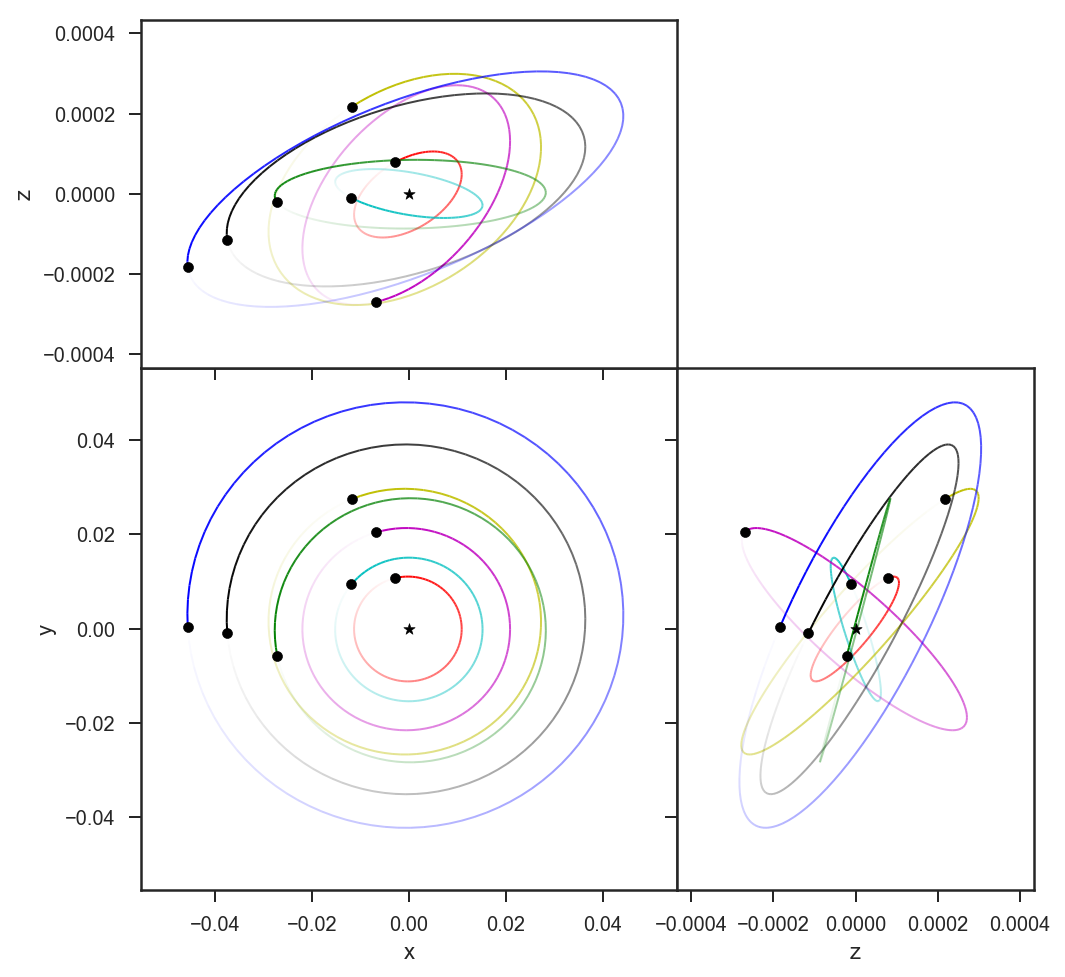

In [34]:
def draw_sim():
    sim = reb.Simulation()
    sim.G = 4.0*pi*pi
    sim.exit_max_distance = 1 # Raise an exception if any body goes beyond 1 AU.
    sim.integrator = "whfast" # Hermes uses the Wisdom-Holman scheme with close encounters integrated by IAS15
    sim.ri_whfast.safe_mode = 0 # This and the next setting are much faster, but only OK if you don't access the particle array between steps
    sim.ri_whfast.corrector = 11 # Same
    sim.dt = 0.05*pi/3.0*1.51087081*days # Close to 5% of inner orbit period, but not commensurate

    add_trappista(sim)
    add_trappistp(sim, 1.51087081, 0.6e-6, 7322.51736, 0.00010, 0.85, 0.72)
    add_trappistp(sim, 2.4218233, 0.17e-5, 7282.80728, 0.00019, 1.38, 0.61)
    add_trappistp(sim, 4.049610, 0.63e-4, 7670.14165, 0.00035, 0.41, 0.27)
    add_trappistp(sim, 6.099615, 0.11e-4, 7660.37859, 0.00038, 0.62, 0.58)
    add_trappistp(sim, 9.206690, 0.15e-4, 7671.39767, 0.00023, 0.68, 0.18)
    add_trappistp(sim, 12.35294, 0.12e-3, 7665.34937, 0.00021, 0.94, 0.63)
    add_trappistp(sim, 20.0, 6.0, 7662.55463, 0.00056, 0.755**3, 3.0*0.755**2*0.034)

    sim.move_to_com()
    
    return sim

sim = draw_sim()
E0 = sim.calculate_energy()

# Make a pretty plot.
reb.OrbitPlot(sim, color=True, slices=True)

sim.status()

For those without access to `rebound` or who just prefer C or C++, here is a suite of initial conditions (1k) in all.  The format is 

* One line with the 8 masses of the star and planets (in orbital order)
* Eight lines giving "x y z vx vy vz" for each object (in the COM frame)

You can use these initial conditions to fulfill parts of the project using your own code if you like.

Note that you can access all the particles in a simulation via `sim.particles`; each particle has its own orbital elements (`p.e`, `p.omega`, `p.pomega`, `p.Omega`, `p.a`, `p.l` (mean longitude), `p.i`, `p.P` (period), etc) in addition to the six-dimensional $\vec{x}$ and $\vec{v}$ that we use below

In [9]:
with open("ics.dat", "w") as out:
    for i in range(1000):
        s = draw_sim()
        ps = s.particles
        mass_line = " ".join(["{:g}".format(p.m) for p in ps])
        out.write(mass_line + "\n")
        for p in ps:
            xv_line = " ".join(["{:g}".format(x) for x in [p.x, p.y, p.z, p.vx, p.vy, p.vz]])
            out.write(xv_line + "\n")

* **For 5 marks** Write your own code (i.e. not rebound) that loads one of these initial conditions and integrates the system for 1000 years.  Remember: this is just Newtonian gravity:
$$
\vec{a}_i = \sum_{j \neq i} \frac{G M_j \left( \vec{r}_j - \vec{r}_i \right)}{\left| \vec{r}_j - \vec{r}_i \right|^3}
$$
Plot the trajectories of the system in the $x$-$y$ plane for the first and last 10 years.  Is your system unstable over 1000 years?

Let's do the above 5-mark part with rebound.  First, we set up a simulation, and initialise an archive stored on disk in "1000yr.bin".  We will have the archive store its state every year (or so).

In [10]:
sim = draw_sim()
sim.initSimulationArchive("1000yr.bin", interval=1)

Now we integrate the system to 1000 years.  The state of the system will be stored 1 year or so; we don't force the integrator to stop evenly on 1-year boundaries, but rather let it keep its step-size and just record the state at the *closest* step to 1-year boundaries.  (Note that we don't have to make the simulation archive if we don't want to save the intermediate states of the system---we can just call `sim.integrate` without setting up the archive.)

In [11]:
sim.integrate(1000, exact_finish_time=0)

Now we can load the archive and make some plots:

In [12]:
sa = reb.SimulationArchive("1000yr.bin")
print("Maximum time achieved = {:g}".format(sa[-1].t))

Maximum time achieved = 1000


Let's check the energy error in the simulation (note that energy should be exactly conserved, so any difference between the initial energy and subsequent energies is down to integration error).

* **For 2 marks** if you have written your own code to do the simulations, make a similar plot of the energy error over your 1000 yr simulation.

Energy error = 1.19197e-07


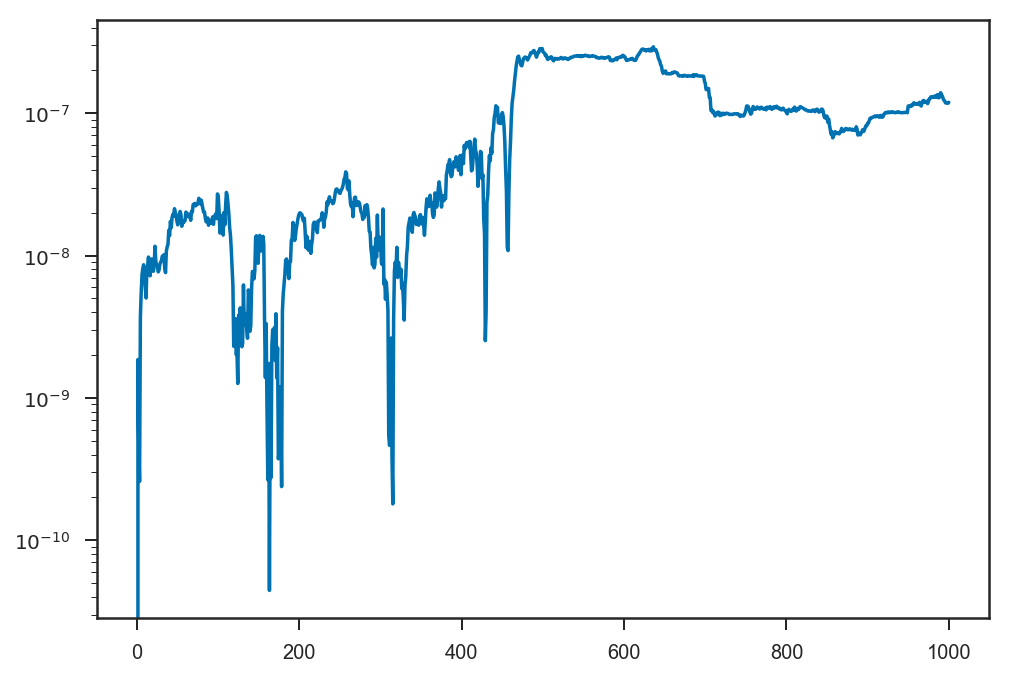

In [13]:
E0 = sa[0].calculate_energy()
es = array([s.calculate_energy() for s in sa])
ts = array([s.t for s in sa])
plot(ts, abs((es-E0)/E0))
yscale("log")
print("Energy error = {:g}".format(abs(1.0-sa[-1].calculate_energy()/E0)))

Let's plot the state of the system at the beginning and end of our simulation:

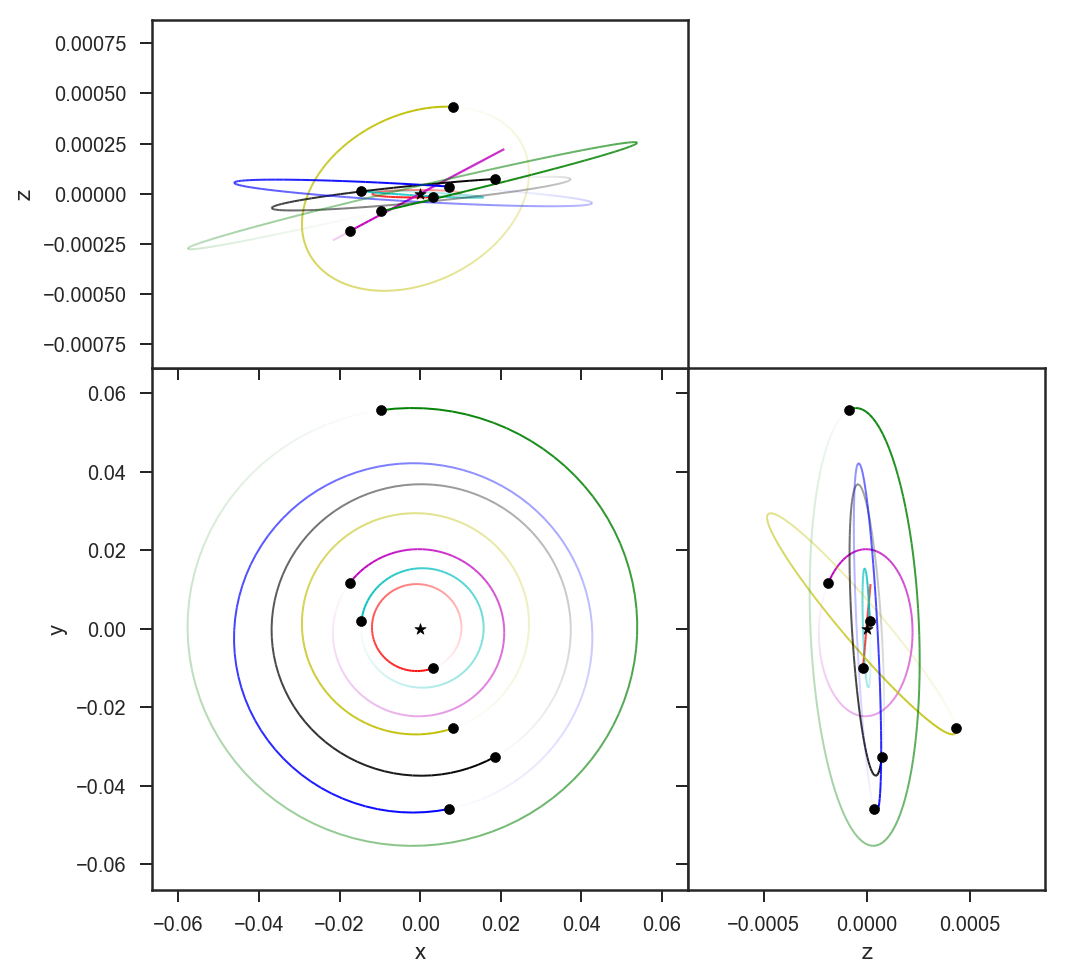

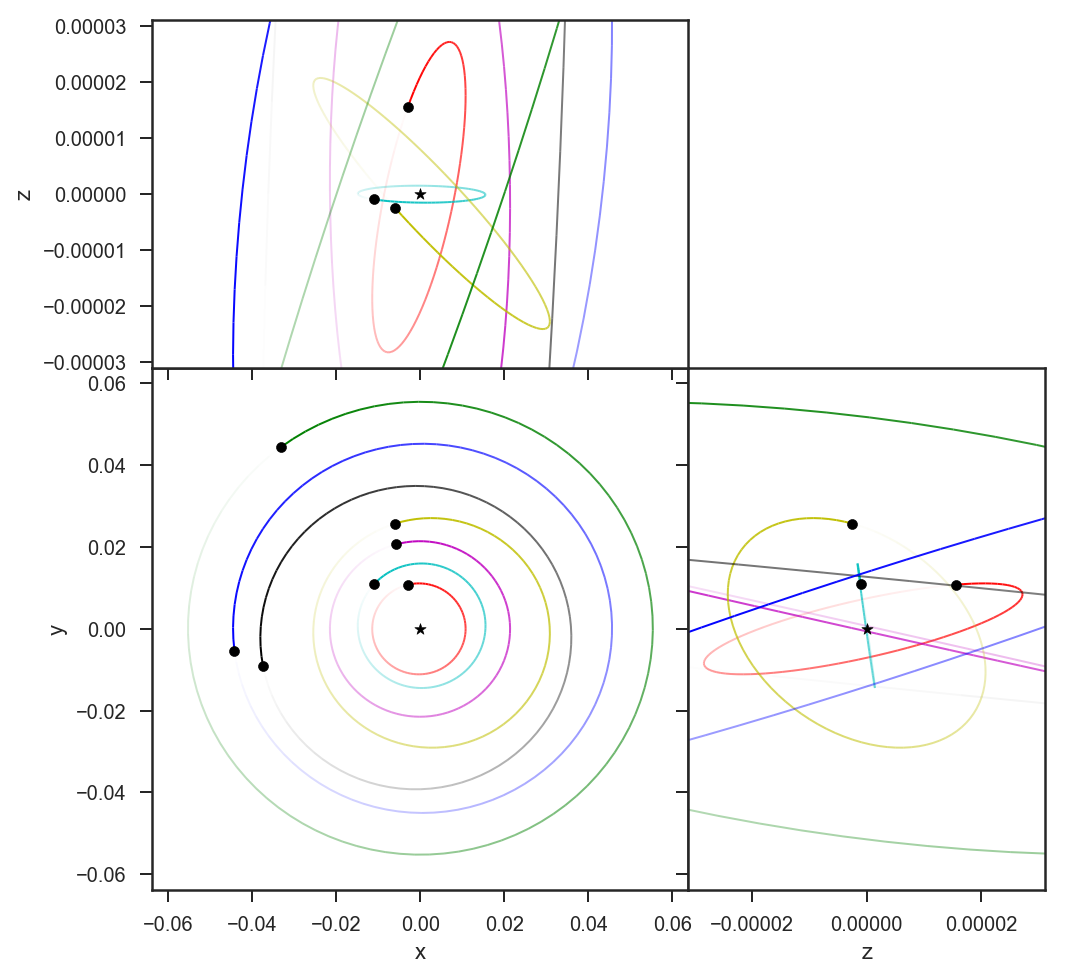

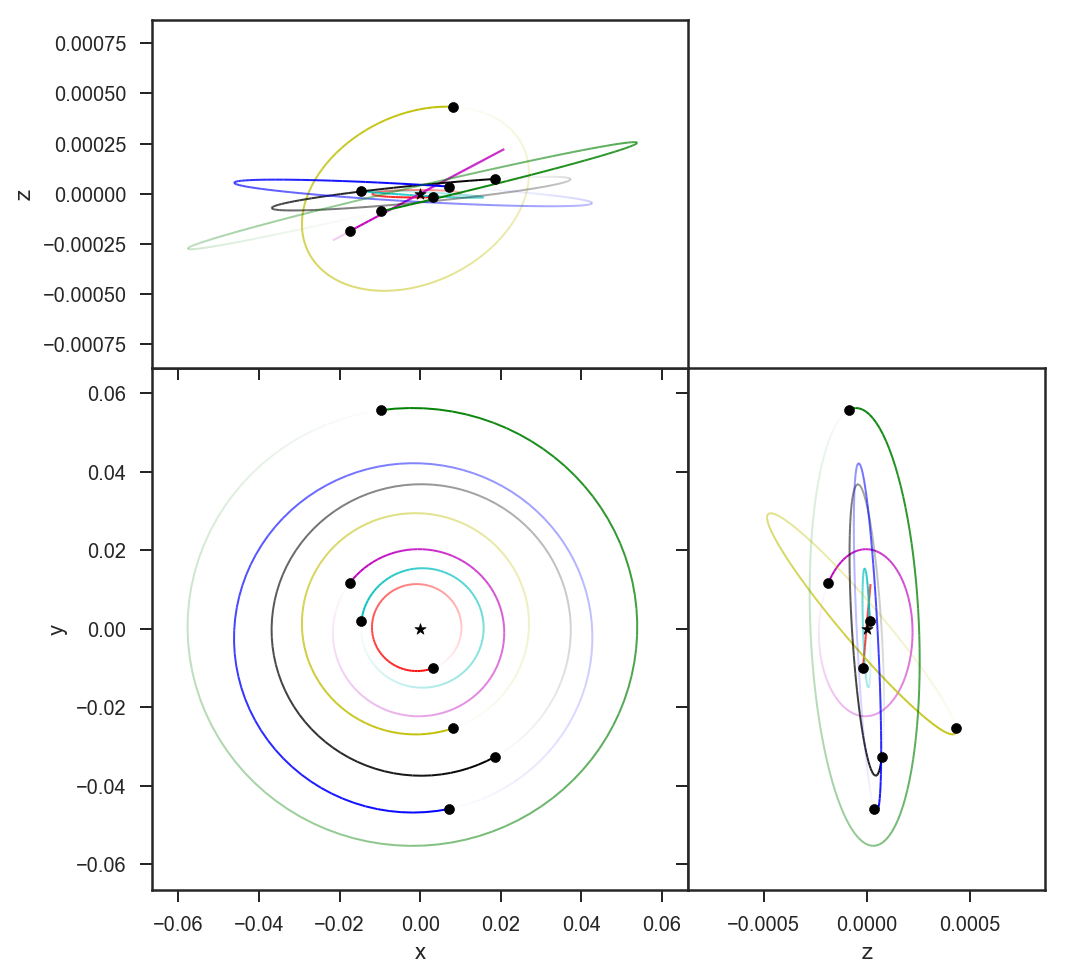

In [14]:
reb.OrbitPlot(sa[0], color=True, slices=True) # Beginning
reb.OrbitPlot(sa[-1], color=True, slices=True) # End

Now let's plot the eccentricity of each planet as a function of time over our simulation.

* **For 2 marks** If you have written your own code to simulate the system, make this plot.  Note that you can calculate the eccentricity using the following two formulas for the energy and angular momentum of an orbit:
$$
E_\mathrm{orb} = -\frac{G M m}{2 a}
$$
and 
$$
\frac{L}{L_\mathrm{circ}} = \sqrt{1-e^2}
$$
with 
$$
L_\mathrm{circ} = m \sqrt{G M a}
$$
you can calculate the energy and angular momentum of the orbit at any instant by computing the separation between a planet and the star and the relative velocity between these two, and then 
$$
E \simeq \frac{1}{2} m v_\mathrm{rel}^2 - \frac{G M m}{r}
$$
and 
$$
L \simeq m \left| \vec{v}_\mathrm{rel} \times \vec{r} \right|
$$
since $m \ll M$.


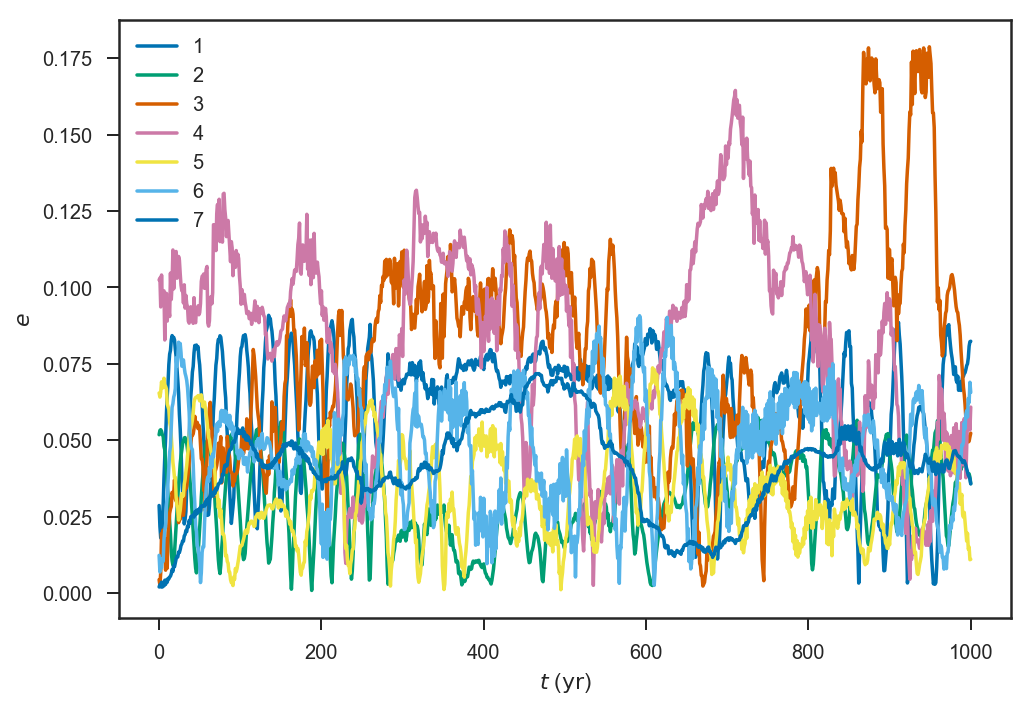

In [15]:
ts = []
es = []
for s in sa:
    ts.append(s.t)
    es.append([p.e for p in s.particles[1:]])
ts = array(ts)
es = array(es)
plot(ts, es)
legend(["{:d}".format(i) for i in range(1,8)], loc='best')
xlabel(r"$t$ ($\mathrm{yr}$)")
ylabel(r"$e$")

It looks like, in this particular simulation, there are a number of quasi-periodic oscillations in the eccentricity of some of the planets.  This is a standard feature of planets in disks with small eccentricity; essentially we are seeing the normal modes of the system.  If you want to know more, look up "Laplace-Lagrange theory," or see [Murray & Dermott](http://amzn.eu/fdMpHFk), Chapter 7.

What about resonances?  The discovery paper states that the inner two planets are near a 5:8 commensurability; is there a corresponding resonant angle:
$$
\theta_\mathrm{res} = 5 \lambda_1 - 8 \lambda_2 + 3 \begin{cases}\varpi_1 & \mathrm{inner} \\
\varpi_2 & \mathrm{outer}\end{cases}
$$
that oscillates?

In [16]:
ts = []
theta_inner = []
theta_outer = []
for s in sa:
    ts.append(s.t)
    ps = s.particles
    theta_inner.append(mpi_to_pi(5*ps[1].l - 8*ps[2].l + 3*ps[1].pomega))
    theta_outer.append(mpi_to_pi(5*ps[1].l - 8*ps[2].l + 3*ps[2].pomega))
ts = array(ts)
theta_inner = array(theta_inner)
theta_outer = array(theta_outer)

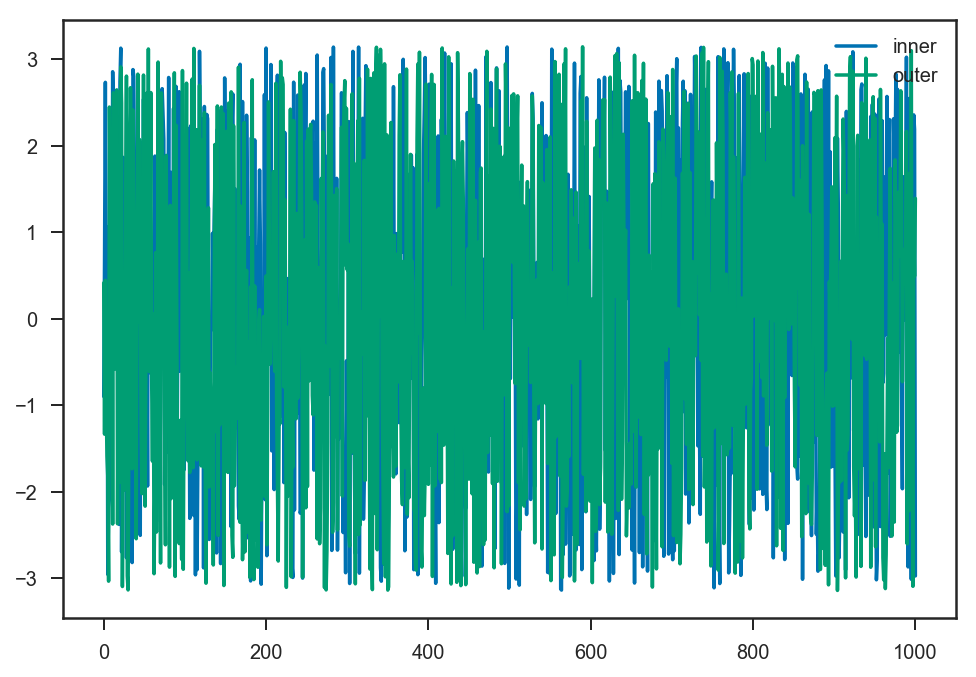

In [17]:
plot(ts, theta_inner, label="inner")
plot(ts, theta_outer, label="outer")
legend(loc="best")

Apparently not.

From here, there are a number of ways to proceed in the assignment; pick whichever combination of tasks you would prefer.  I will mark everything you do, but the maximum score is 10 marks; only do significantly more than 10 marks worth of work if you are excited to explore these topics (good for you!).

* **For 2 marks** Find an initial condition that goes unstable (a planet escapes) within 10k years.  Plot the initial configuration; can you guess that this would be unstable based on the planetary spacings?
* **For 2 marks** Estimate the *fraction* of draws that result in unstable systems on 10k year timescales.  
* **For 2 marks** Plot the 7th planet mass and initial period for a ensemble of simulations integratied over 10k yr.  Indicate on your plot which values resulted in stable systems and which gave unstable systems; do you see a pattern?
* **For 3 marks** Check that the initial conditions we generated have the correct transit times.  Look up the times of each planet's transit in the discovery paper, and integrate the system to a transit (via `sim.integrate((t_transit - epoch)*days)` or using your own code).  Verify that the appropriate planet is close to the $x$-axis at the transit time.
* **For 4 marks** Look for resonances in some integrations of the system (see the discovery paper for a list of possible commensurabilites).  You will have the best luck looking for lower order resonances (the inner two planets could be in a third order resonance---$5$:$8$---whose strength will scale as $e^3$, which is pretty weak).  You don't have to find any, but show at least ten different searches if you don't find one.
* **For 5 marks** For an ensemble of simulations over 10k yr (at least ~100), record the planet masses from the *stable* simulations.  Plot a histogram of the masses of the 7th planet; compare to the Gaussian distribution used to draw simulations above.  Does the demand for stability constrain the mass of the seventh planet beyond what is already known from the transit observations?  Plot such a histogram for all the planets; do you obtain better constraints on the masses of the inner planets, too?
* **For 5 marks** One of the signs of near-resonant or resonant orbits are *transit timing variations* (TTVs).  Given that transits occur when a planet crosses the $x$-axis (here assume for simplicity 2D orbits, so this is equivalent to $y = 0$), write code that integrates the system for 10s of years and extracts the times of all transits of one (or several, if you like) of the planets.  Plot $t_\mathrm{transit} \mod P$ for all the transits; if the orbit were strictly periodic, you would see a consistent orbital phase at transit (i.e. a horizontal line).  Do you?  If not, how significant are the transit time variations?  